# Infogan



![대체 텍스트](https://drive.google.com/uc?id=18oQDfrHQUDg7hMrBs-v2-2aMiNJYxnJm)

## TensorFlow 및 기타 라이브러리 가져오기

In [0]:
import tensorflow as tf
slim = tf.contrib.slim
tfd = tf.distributions

from tensorflow.examples.tutorials.mnist import input_data

Load the MNIST dataset.

In [0]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


## Defining the Adversarial Networks



![title](https://drive.google.com/uc?id=18msRuNcK_oXw2UReSrya0fcpRT-ZKdzZ )


### Generator Network
The generator takes a vector of random numbers and transforms it into a 32x32 image. Each layer in the network involves a strided transpose convolution, batch normalization, and rectified nonlinearity. Tensorflow's slim library allows us to easily define each of these layers.

In [0]:
def generator(z, out_activation_fn=tf.nn.sigmoid):
  """Generate images from latents."""
  with slim.arg_scope([slim.fully_connected, slim.conv2d_transpose],
                      normalizer_fn=slim.batch_norm):
    with slim.arg_scope([slim.conv2d_transpose], kernel_size=4, stride=2):
      net = slim.fully_connected(z, 1024)
      net = slim.fully_connected(net, 7 * 7 * 128)
      net = tf.reshape(net, [-1, 7, 7, 128])
      net = slim.conv2d_transpose(net, 64)
      net = slim.conv2d_transpose(net, 1,
                                  normalizer_fn=None,
                                  activation_fn=None)
      net = out_activation_fn(net)
      return net

### Discriminator Network
The discriminator network takes as input a 32x32 image and transforms it into a single valued probability of being generated from real-world data. Again we use tf.slim to define the convolutional layers, batch normalization, and weight initialization.

In [0]:
def discriminator(x, cat_dim, cont_dim, fix_cont_std=True):
  """Discriminate real vs. fake and predict latents from an input image.
  
  Args:
    x: Tensor of images
    cat_dim: dimension of categorical variable
    cont_dim: number of continuous latent variables
    fix_cont_std: whether to fix the standard deviation of the approximate
      posterior for the continuous latent variables to 1.0 
      
  Returns:
    q_real: predicted distribution over real vs. fake
    q_cat: predicted distribution over categorical variable
    q_cont: predicted distribution over continuous variable
  """
  with slim.arg_scope([slim.conv2d, slim.fully_connected],
                      activation_fn=tf.nn.leaky_relu):
    with slim.arg_scope([slim.conv2d], kernel_size=4, stride=2):
      net = slim.conv2d(x, 64, normalizer_fn=None)
      net = slim.conv2d(net, 128, normalizer_fn=slim.batch_norm)
      net = slim.flatten(net)
      net = slim.fully_connected(net, 1024, normalizer_fn=slim.batch_norm)

      # Logits for binary real vs. fake GAN discriminator
      logits_real = slim.fully_connected(net, 1, activation_fn=None)
      q_real = tfd.Bernoulli(logits=logits_real)

      # Recognition network for latent variables has an additional layer 
      encoder = slim.fully_connected(net, 128, normalizer_fn=slim.batch_norm)

      # Compute logits for each category of categorical latent
      logits_cat = slim.fully_connected(encoder, cat_dim, activation_fn=None)
      q_cat = tfd.Categorical(logits=logits_cat)

      # Compute mean and variance for Gaussian posterior of continuous latents
      cont_vars = slim.fully_connected(encoder, cont_dim * 2, activation_fn=None)
      cont_mu = cont_vars[:, :cont_dim]
      if fix_cont_std:
        cont_sigma = tf.ones_like(cont_mu)
      else:
        cont_sigma = tf.nn.softplus(cont_vars[:, cont_dim:])
      q_cont = tfd.Normal(loc=cont_mu, scale=cont_sigma)
      return q_real, q_cat, q_cont

## Connecting them together

In [0]:
# Incompressible noise dimensionality (not reconstructed)
noise_dim = 62
# Dimensionality of the single categorical variable
cat_dim = 10
# Number of continuous latent variables
cont_dim = 2
# Weighting on InfoGAN regularization term
info_reg_coeff = 1.0
# Generator/discriminator learning rate
gen_lr = 1e-3
disc_lr = 2e-4

In [0]:
NB=128
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [0]:
tf.reset_default_graph()
images_np = mnist.train.images
images_np = images_np.reshape(-1, 28, 28, 1)
dataset = tf.data.Dataset.from_tensor_slices(images_np)
dataset = dataset.shuffle(100).repeat()
dataset = dataset.apply(
    tf.contrib.data.batch_and_drop_remainder(NB))
images = dataset.make_one_shot_iterator().get_next()

# Generate samples from prior
z_cat = tfd.Categorical(logits=tf.zeros([NB, cat_dim])).sample()
z_cat_one_hot = tf.one_hot(z_cat, cat_dim)

z_noise = tfd.Uniform(low=-tf.ones([NB, noise_dim]),
                      high=tf.ones([NB, noise_dim])).sample()
z_cont = tfd.Uniform(low=-tf.ones([NB, cont_dim]),
                     high=tf.ones([NB, cont_dim])).sample()
# Concatenate incompressible noise, discrete latents, and continuous latents
z = tf.concat([z_noise, z_cat_one_hot, z_cont], axis=1)

# Construct generator and discriminator networks
with slim.arg_scope(
    [slim.fully_connected, slim.conv2d_transpose],
    weights_initializer=tf.random_normal_initializer(stddev=0.02)):
  with slim.arg_scope(
      [slim.conv2d],
      weights_initializer=tf.truncated_normal_initializer(stddev=0.02)):
    with tf.variable_scope('gnet'):
      with slim.arg_scope([slim.batch_norm], is_training=True):
        generated = generator(z)
    with tf.variable_scope('gnet', reuse=True):
      with slim.arg_scope([slim.batch_norm], is_training=False):
        generated_test = generator(z)
    with tf.variable_scope('dnet'):
      d_real, cat_real, cont_real = discriminator(images, cat_dim, cont_dim)
    with tf.variable_scope('dnet', reuse=True):
      d_fake, cat_fake, cont_fake = discriminator(generated, cat_dim, cont_dim)

In [0]:
# Normal GAN objectives
real_labels = tf.ones([NB, 1])
fake_labels = tf.zeros([NB, 1]) 
gan_d_loss = -(tf.reduce_mean(d_real.log_prob(real_labels)) + 
               tf.reduce_mean(d_fake.log_prob(fake_labels)))
gan_g_loss = -tf.reduce_mean(d_fake.log_prob(real_labels))

# InfoGAN loss
log_prob_cat = tf.reduce_sum(cat_fake.log_prob(z_cat)) / NB
log_prob_cont = tf.reduce_sum(cont_fake.log_prob(z_cont)) / NB
infogan_loss = -info_reg_coeff * (log_prob_cat + log_prob_cont)

# Generator and discriminator loss are the same as a GAN but with the added
# regularization to reconstruct a subset of latents from the image
d_loss = gan_d_loss + infogan_loss
g_loss = gan_g_loss + infogan_loss

# Optimization
global_step = tf.train.get_or_create_global_step()
dvars = tf.contrib.framework.get_variables('dnet')
gvars = tf.contrib.framework.get_variables('gnet')
gen_opt = tf.train.AdamOptimizer(gen_lr, 0.5)
disc_opt = tf.train.AdamOptimizer(disc_lr, 0.5)
train_gen_op = gen_opt.minimize(g_loss, global_step, var_list=gvars)
update_ops = (tf.get_collection(tf.GraphKeys.UPDATE_OPS))
with tf.control_dependencies(update_ops + [train_gen_op]):
  train_op = disc_opt.minimize(d_loss, global_step, var_list=dvars)

In [0]:
from IPython.display import display
import matplotlib.pyplot as plt
plt.ioff()
def display_imgs(gens):
  fig, axs = plt.subplots(1, 10, figsize=(10, 1))
  for i in range(10):
    axs.flat[i].imshow(gens[i].squeeze(), interpolation='none', cmap='gray')
    axs.flat[i].axis('off');
  return fig, axs

## Training

/usr/local/lib/python3.5/dist-packages/tensorflow/python/client/session.py:1714: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


0 [None, 0, -2.327159, -2.1789455, 4.5061045, 1.3880365, 0.59111595]


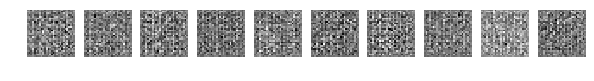

2000 [None, 4000, -0.007250264, -1.8627479, 1.8699982, 1.2644347, 0.8071923]


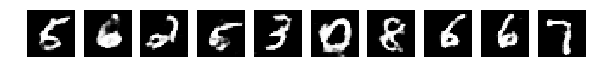

4000 [None, 8000, -0.01169065, -1.8644019, 1.8760926, 1.169558, 0.8424356]


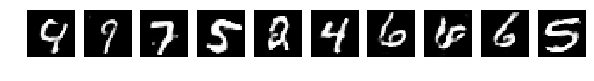

6000 [None, 12000, -0.0004616881, -1.8571243, 1.857586, 1.1411151, 0.91398096]


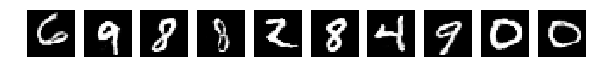

8000 [None, 16000, -0.0032290358, -1.862297, 1.8655261, 1.1002097, 0.9344771]


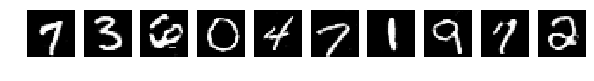

10000 [None, 20000, -0.0029236812, -1.8646264, 1.8675501, 0.804042, 1.5057843]


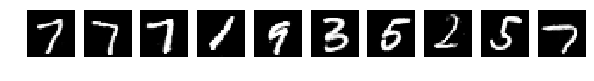

12000 [None, 24000, -0.0007772891, -1.8555279, 1.8563051, 0.8957257, 1.1693125]


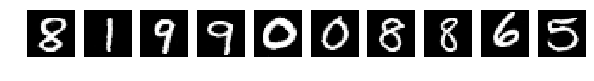

14000 [None, 28000, -0.0018209602, -1.8609339, 1.8627548, 0.7729531, 1.3288733]


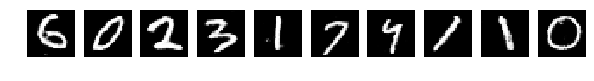

16000 [None, 32000, -0.0010023048, -1.8614708, 1.8624731, 0.74827844, 1.4643912]


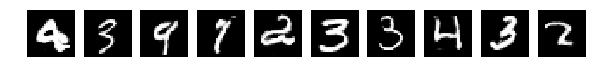

18000 [None, 36000, -0.0044489834, -1.8604046, 1.8648536, 0.6451303, 1.8577021]


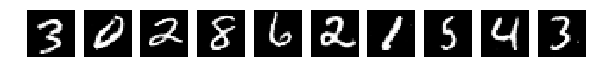

20000 [None, 40000, -0.0018222937, -1.8650082, 1.8668306, 0.4829943, 1.9339414]


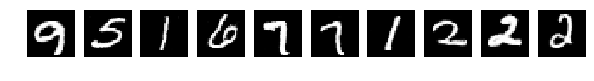

In [0]:
sess = tf.InteractiveSession()
sess.run(tf.initialize_all_variables())
steps = 20000

outs = []
for i in range(steps+1):
  out = sess.run([train_op, global_step, log_prob_cat, log_prob_cont, infogan_loss, gan_d_loss, gan_g_loss, generated])
  outs.append(out[1:-1])
  if i % (steps//10) == 0:
    print(i, out[:-1])
    fig, ax = display_imgs(out[-1])
    display(fig)
    plt.close(fig)

## Visualization

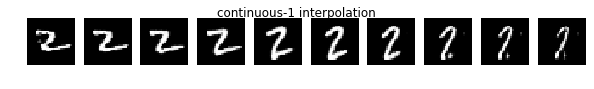

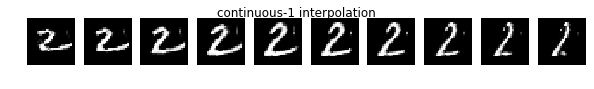

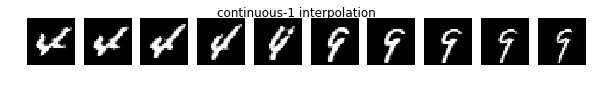

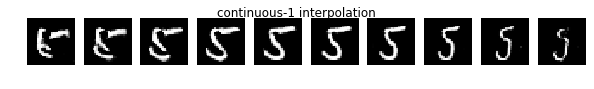

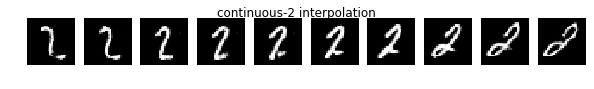

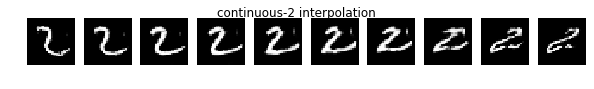

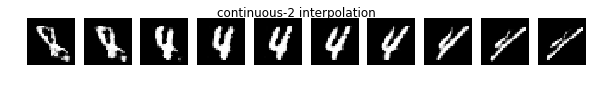

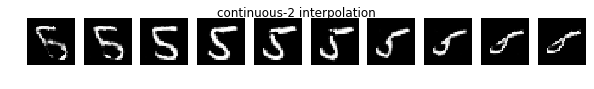

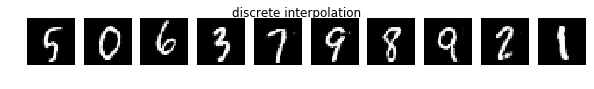

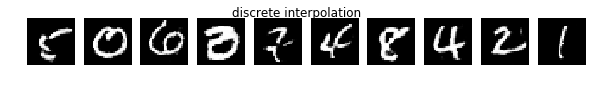

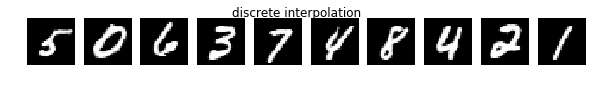

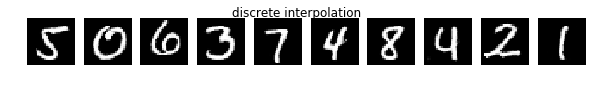

In [0]:
np_z = sess.run(z)

for interp in ('continuous-1', 'continuous-2', 'discrete'):
  for i in range(4):
    z_new = np_z.copy()
    z_new[:] = z_new[i:i+1]
    if 'continuous' in interp:
      idx = int(interp.split('-')[1])
      z_new[:10, -idx] = np.linspace(-2, 2, 10)
    else:
      z_new[:cat_dim, noise_dim:noise_dim+cat_dim] = np.eye(cat_dim)
    samples = sess.run(generated_test, {z: z_new})
    display_imgs(samples);
    plt.suptitle(interp + ' interpolation')
    plt.show()

## Reference 
---
### 구현 저자 : Ben Poole, Kumar Krishna Agrawal  

[참조링크1](https://colab.research.google.com/drive/1JkCI_n2U2i6DFU8NKk3P6EkPo3ZTKAaq#scrollTo=qCa2lSXCohCX)  
### 참고하기 좋은 코드:
[참조링크2](https://github.com/jiema58/InfoGan-Mnist/blob/master/InfoGan.ipynb)  
[참조링크3](https://github.com/openai/InfoGAN)  
### Infogan 이론 자료 :  
[1]InfoGAN 논문 [링크](https://arxiv.org/abs/1606.03657)  
[2]infoGAN 이론 설명(영문) [링크](https://towardsdatascience.com/infogan-generative-adversarial-networks-part-iii-380c0c6712cd)   
[3]infoGAN 이론 설명(한글) [링크](https://taeoh-kim.github.io/blog/generative-models-part-2-improvedganinfoganebgan)  
 